In [59]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn.neighbors import KNeighborsClassifier # testing if KNN is better


In [60]:
# load cleaned dataset
df = pd.read_csv("../data/processed/cleaned_rentals_25k.csv")
print("Dataset loaded with shape:", df.shape)
df.head()

Dataset loaded with shape: (25293, 169)


,rentfaster_id,city,province,address,latitude,longitude,price,beds,baths,sq_feet,...,availability_date_September 14,availability_date_September 15,availability_date_September 19,availability_date_September 29,availability_date_September 30,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,2495.0,2.0,2.5,1403.0,...,False,False,False,False,False,True,False,False,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,2695.0,3.0,2.5,1496.0,...,False,False,False,False,False,True,False,False,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,2295.0,2.0,2.5,1180.0,...,False,False,False,False,False,True,False,False,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,2095.0,2.0,2.5,1403.0,...,False,False,False,False,False,True,False,False,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,2495.0,2.0,2.5,1403.0,...,False,False,False,False,False,True,False,False,True,True


In [61]:
# Keep only the desired columns
cols_to_keep = [
    "sq_ft", "beds", "baths", "type_Townhouse", "furnishing_Negotiable","furnishing_Unfurnished",
     "type_Basement","type_Condo Unit","type_Main Floor", "latitude", "longitude", "price",
     "smoking_Non-Smoking","smoking_Smoke Free Building","cats_True","dogs_True"
     "lease_term_6 months","lease_term_Long Term","lease_term_Negotiable","lease_term_Short Term"
]
available_cols = [col for col in cols_to_keep if col in df.columns]
df = df[available_cols].dropna()
print("Dataset loaded with shape:", df.shape)
df.head()


Dataset loaded with shape: (25293, 17)


,beds,baths,type_Townhouse,furnishing_Negotiable,furnishing_Unfurnished,type_Basement,type_Condo Unit,type_Main Floor,latitude,longitude,price,smoking_Non-Smoking,smoking_Smoke Free Building,cats_True,lease_term_Long Term,lease_term_Negotiable,lease_term_Short Term
0,2.0,2.5,True,False,True,False,False,False,51.305962,-114.012515,2495.0,True,False,True,True,False,False
1,3.0,2.5,True,False,True,False,False,False,51.305962,-114.012515,2695.0,True,False,True,True,False,False
2,2.0,2.5,True,False,True,False,False,False,51.305962,-114.012515,2295.0,True,False,True,True,False,False
3,2.0,2.5,True,False,True,False,False,False,51.305962,-114.012515,2095.0,True,False,True,True,False,False
4,2.0,2.5,True,False,True,False,False,False,51.305962,-114.012515,2495.0,True,False,True,True,False,False


In [62]:
#Step 2: Load the regression model 
regression_model = joblib.load("linear_regression_model.pkl")

In [63]:
#Step 3: Predict fair prices and label data 
X_reg = df.drop(columns=["price"])
y_actual = df["price"].values

predicted_price = regression_model.predict(X_reg)

price_ratio = y_actual / predicted_price
labels = []
for ratio in price_ratio:
    if ratio < 0.9:
        labels.append("underpriced")
    elif ratio > 1.1:
        labels.append("overpriced")
    else:
        labels.append("fair")

df["label"] = labels

In [64]:
#Step 4: Train Random Forest Classifier
X = X_reg.copy()
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = KNeighborsClassifier(n_neighbors=5)  # Using KNN for testing purposes
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Classification Report:

              precision    recall  f1-score   support

        fair       0.77      0.76      0.76      1928
  overpriced       0.80      0.82      0.81      1417
 underpriced       0.82      0.82      0.82      1714

    accuracy                           0.80      5059
   macro avg       0.80      0.80      0.80      5059
weighted avg       0.80      0.80      0.80      5059

Confusion Matrix:



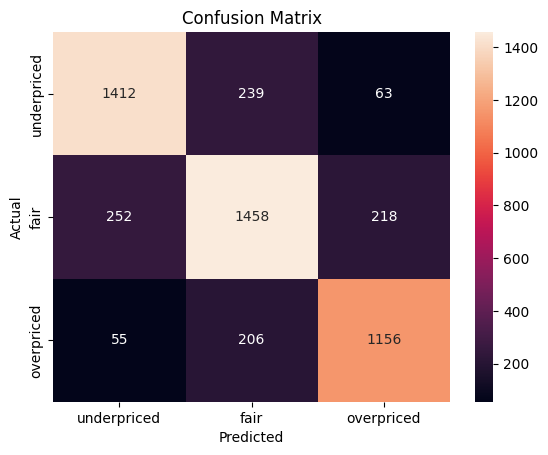

In [65]:
#Step 5: Evaluate the classifier 
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_test, y_pred, labels=["underpriced", "fair", "overpriced"])
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["underpriced", "fair", "overpriced"], yticklabels=["underpriced", "fair", "overpriced"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
#Step 6: Save the classifier model 
joblib.dump(clf, "classifier_model.pkl")
print("Classifier saved to notebooks/classifier_model.pkl")

Classifier saved to models/classifier_model.pkl
